In [13]:
import time, sys, math, copy
#sys.path.append('/path/to/env/lib/python3.6/site-packages')
import numpy as np
from matplotlib import pyplot as plt 

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import import_ipynb
from MoveData import Options, json2datatools, num_batches, nopeak_mask, create_masks

%matplotlib inline

If you are not using this notebook to learn, change the below variable `teaching` to False, if you are here to learn, change it to True

In [2]:
teaching = True 

Before going into this lesson, lets remind ourselves where the components we are about to learn fit into the big picture. Recall the overall architecture of the Transformer. It is useful to image yourself as a piece of data, then imagine the journey you are about to go on. 

Imagine you emerge from the `data_iter` function and into the transformer, the first place you will go is the encoder. initialized using `self.encoder = Encoder(in_vocab_size, emb_dim, n_layers, heads, dropout)` and used in the form `e_output = self.encoder(src_seq, src_mask)` 

In [2]:
class Transformer(nn.Module):
    def __init__(self, in_vocab_size, out_vocab_size, emb_dim, n_layers, heads, dropout):
        super().__init__()
        self.encoder = Encoder(in_vocab_size, emb_dim, n_layers, heads, dropout)
        self.decoder = Decoder(out_vocab_size, emb_dim, n_layers, heads, dropout)
        self.out = nn.Linear(emb_dim, out_vocab_size)
    def forward(self, src_seq, trg_seq, src_mask, trg_mask):
        e_output = self.encoder(src_seq, src_mask)
        d_output = self.decoder(trg_seq, e_output, src_mask, trg_mask)
        output = self.out(d_output)
        return output

The first component, or module, within the Encoder, is the Embedder. emb_dim is short for embedding_dimensions

`self.embed = Embedder(vocab_size, embedding_dimensions)` 

`x = self.embed(source_sequence)`

In [3]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, n_layers, heads, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.embed = Embedder(vocab_size, emb_dim)
        self.pe = PositionalEncoder(emb_dim, dropout=dropout)
        self.layers = get_clones(EncoderLayer(emb_dim, heads, dropout), n_layers)
        self.norm = Norm(emb_dim)
    def forward(self, src_seq, mask):
        x = self.embed(src_seq)
        x = self.pe(x)
        for i in range(self.n_layers):
            x = self.layers[i](x, mask)
        x = self.norm(x)
        return x

## Embedding

What is it Embedding? As we mentioned before, one ability, or limitation depending on how you look at it, of chloe is her fixed vocabulary, each word or symbol in her vocabulary is assigned an integer. For example the word hi is assigned 3, the word dog is 17, a word not in the vocabulary is 0. This integer is the `token` index. 

The neural nework sees every word as a vector. [A vector of 3 real numbers forms the coordinates in 3D space](https://youtu.be/fNk_zzaMoSs). We use several more dimensions than 3 in deep learning, if we use 512 dimensions, our `embedding_dimensions = 512`, this means that each word is a point in 512 dimensional space. The same concepts apply to 3D space in that the location of that word in 3D space tells you it's [meaning and meaning relative to other words](https://youtu.be/8rXD5-xhemo?t=1550).

<img src="../saved/images/wordvectors.png" height=400 width=400>

In the image you see above, similar words are close to each other, not only that, the direction they are separated from eachother also carries meaning. In the image, there are 3 clusters of words and the separation between them has something to do with age/time/etc.  

If you stack all the vectors on top of eachother row by row, you get a matrix. Remember how each word is represented by both a vector and an integer? well this integer is the index for a row in the matrix. The matrix is called the embedding matrix. you might say that we "embed" words into the matrix. Now for the example, run the cells below 

In [4]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.embed = nn.Embedding(vocab_size, emb_dim)
    def forward(self, x):
        return self.embed(x)

To demonstrate the Embedder, I will show you it's two functions

- storing an embedding matrix of word vectors 
- transforming a sequence of integers that represent token indices, into a sequence of vectors

Lets start off by creating a toy embedding with only 2 tokens in it, these tokens will be represented in 4-dimensional space. After creating the embedding, I pass into the Embedder a sequence of token indices, the integers `[1,0,1]`

In [6]:
if teaching:  
    torch.manual_seed(0)
    embedding = Embedder(vocab_size=2, emb_dim=4)
    source_sequence = torch.from_numpy(np.asarray([1,0,1])).unsqueeze(0)
    print('source_sequence',source_sequence, source_sequence.shape)
    print("---------------------------------------------------")
    print("Embedding Matrix", embedding.embed.weight, embedding.embed.weight.shape)
    print("---------------------------------------------------")
    sequence_of_vectors = embedding(source_sequence)
    print('sequence_of_vectors',sequence_of_vectors, sequence_of_vectors.shape)

source_sequence tensor([[1, 0, 1]]) torch.Size([1, 3])
---------------------------------------------------
Embedding Matrix Parameter containing:
tensor([[ 1.5410, -0.2934, -2.1788,  0.5684],
        [-1.0845, -1.3986,  0.4033,  0.8380]], requires_grad=True) torch.Size([2, 4])
---------------------------------------------------
sequence_of_vectors tensor([[[-1.0845, -1.3986,  0.4033,  0.8380],
         [ 1.5410, -0.2934, -2.1788,  0.5684],
         [-1.0845, -1.3986,  0.4033,  0.8380]]], grad_fn=<EmbeddingBackward>) torch.Size([1, 3, 4])


## Embedding Matrix

Suppose, as I mentioned earlier, I am unhappy with chloe's limited vocabulary `{"me":0, "give":1}`. I want her to learn the word "covfefe". I will have to add a word to her dictionary `{"covfefe":2}` (not shown), then I will have to initialize a new word vector and add it, concatenate it, to chloe's embedding matrix `embedding.embed.weight`. In the cell below, I do just that. 

`concatenated_matrix` is the concatenation of the old matrix `embedding.embed.weight` with the `new_vector` appended to the bottom row. Now we can embed our

sequence of integers **(batch_size, sequence_length)** 

into a vector sequence the phrase "give me covfefe"


In [7]:
if teaching:  
    np.random.seed(0)
    new_vector = torch.from_numpy(np.random.uniform(-0.1,0.1,(1, 4)).astype(np.float32))
    print('new_vector', new_vector, new_vector.shape)
    print("---------------------------------------------------")
    concatenated_matrix = torch.cat((embedding.embed.weight, new_vector),dim=0)
    embedding.embed.weight=nn.Parameter(concatenated_matrix,requires_grad=True)
    print("New Embedding Matrix", embedding.embed.weight, embedding.embed.weight.shape)
    print("---------------------------------------------------")
    source_sequence = torch.from_numpy(np.asarray([1,0,2])).unsqueeze(0)
    print('source_sequence',source_sequence, source_sequence.shape)
    print("---------------------------------------------------")
    sequence_of_vectors = embedding(source_sequence)
    print('sequence_of_vectors',sequence_of_vectors, sequence_of_vectors.shape)

new_vector tensor([[0.0098, 0.0430, 0.0206, 0.0090]]) torch.Size([1, 4])
---------------------------------------------------
New Embedding Matrix Parameter containing:
tensor([[ 1.5410, -0.2934, -2.1788,  0.5684],
        [-1.0845, -1.3986,  0.4033,  0.8380],
        [ 0.0098,  0.0430,  0.0206,  0.0090]], requires_grad=True) torch.Size([3, 4])
---------------------------------------------------
source_sequence tensor([[1, 0, 2]]) torch.Size([1, 3])
---------------------------------------------------
sequence_of_vectors tensor([[[-1.0845, -1.3986,  0.4033,  0.8380],
         [ 1.5410, -0.2934, -2.1788,  0.5684],
         [ 0.0098,  0.0430,  0.0206,  0.0090]]], grad_fn=<EmbeddingBackward>) torch.Size([1, 3, 4])


## Positional Encoding

I find it useful to jeep track of the shape of my data as it goes on it's journey through the neural network

After the embedding, the shape is this vector sequence is

**(batch_size, sequence_length, embedding_dimensions)**

`[[-1.0845, -1.3986,  0.4033,  0.8380]`  give

` [ 1.5410, -0.2934, -2.1788,  0.5684 ]`  me

` [ 0.0098,  0.0430,  0.0206,  0.0090]]` covfefe
  
The next step is positional encoding. Imagine that the correct response to the above input 
is "heres your covfefe". This response makes sense given the input only in the order "give me covfefe". If I were to mix them up and say " me give covfefe", you might think that I was about to give you some covfefe, and that I was some sort of caveman. The other popular sequence models are the recurrent neural network (RNN) family of models, these models process the input vectors in chronological order, starting with "give", ending with "covfefe", updating a hidden state at each timestep. The RNN Decoder likewise continues to modify the hidden state as it predicts the output tokens. Transformers on the other hand pay attention to all inputs at each output step. So unless we bake into the vectors some information about it's position in the sequence (first, second, 6th, last, etc), the Transformer will be dealing with essentially a bag of words. 

The paper [Attention is all you need](https://arxiv.org/abs/1706.03762) writes:

"Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension `dmodel` as the embeddings, so that the two can be summed. There are many choices of positional encodings,learned and fixed. In this work, we use sine and cosine functions of different frequencies:
 
 $$\text{PE}(pos,2i)=sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
 
 $$\text{PE}(pos,2i+1)=cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
 
where pos is the position and i is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000·2π. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset k, $$PE_{pos+k}$$ can be represented as a linear function of $$PE_{pos}$$ 

We also experimented with using learned positional embeddings instead, and found that the two versions produced nearly identical results. We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training."

Below is their Positional Encoder in PyTorch built to take in our shape **(batch_size, sequence_length, embedding_dimensions)** sequence of vectors

In [15]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 200, dropout = 0.1):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        # create constant 'pe' matrix with values dependant on pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0) # add a batch dimention to your pe matrix 
        self.register_buffer('pe', pe)
 
    def forward(self, x):
        
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        pe = Variable(self.pe[:,:seq_len], requires_grad=False)
        #print('x.shape', x.shape) # (batch_size, input_seq_len, d_model)
        #print('pe.shape', pe.shape) # (1, input_seq_len, d_model)
        if x.is_cuda:
            pe.cuda()
        x = x + pe
        return self.dropout(x)

Lets take for example the vector for "covfefe" and call it 

$$ e_{w} = [ 0.0098,  0.0430,  0.0206,  0.0090] $$

$$ e_{w}' =  e_{w} + PostionalEncoding = PostionallyEncodedVector$$

Since our vector has only 4 dimensionts, we already have positional encoder for 4 dimensions with i = 0 and i = 1, since for each value i, we get positional encoding for 2i and 2i+1.

2(0)=0, 2(0)+1 = 1, 2(1)=2, 2(1)+1=3

Accoring to the formula above, each of the 2i positions use sine and each of the 2i+1 use cosine, giving us the formula below for how to add a 4 dimensional positional encoding for any given postion *pos*

$$\begin{align*}e_{w}'&= e_{w} + \left[sin\left(\frac{pos}{10000^{2(0)}}\right), cos\left(\frac{pos}{10000^{2(0)}}\right),sin\left(\frac{pos}{10000^{2(1)/4}}\right),cos\left(\frac{pos}{10000^{2(1)/4}}\right)\right]\\
&= e_{w} + \left[sin\left(\frac{pos}{10000^{0}}\right), cos\left(\frac{pos}{10000^{0}}\right),sin\left(\frac{pos}{10000^{2/4}}\right),cos\left(\frac{pos}{10000^{2/4}}\right)\right]\\
&=e_{w} + \left[sin\left(pos\right), cos\left(pos\right),sin\left(\frac{pos}{100}\right),cos\left(\frac{pos}{100}\right)\right]\\
\end{align*}$$

for pos = 1, we get 

$$e_{w}=e_{w} + [0,1,0,1]$$

Look at the first row (first postion) of the positional encoding matrix `positioner.pe[:,:seq_len]`

In [25]:
seq_len = sequence_of_vectors.size(1)

if teaching: 
    positioner = PositionalEncoder(d_model=4, max_seq_len=100, dropout=0.0)
    print(positioner.pe.shape)
    print('seq_len',seq_len)
    print(positioner.pe[:,:seq_len])

torch.Size([1, 100, 4])
seq_len 3
tensor([[[0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00],
         [8.4147e-01, 9.9995e-01, 1.0000e-04, 1.0000e+00],
         [9.0930e-01, 9.9980e-01, 2.0000e-04, 1.0000e+00]]])


another way to look at this is that our encoding [0,1,0,1] is the first column of values in the graph below

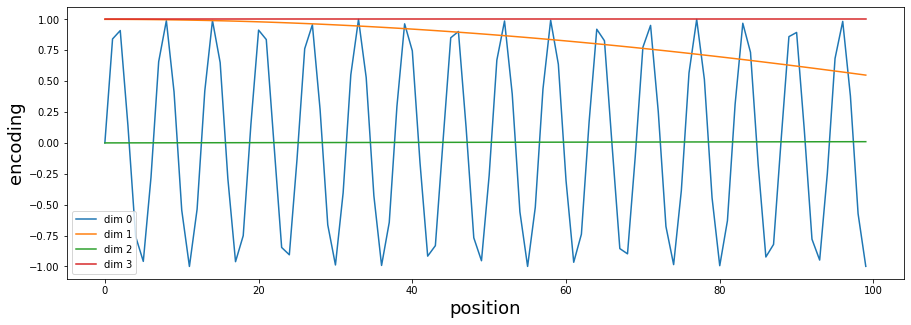

In [24]:
plt.figure(figsize=(15, 5)) 
y = positioner(Variable(torch.zeros(1, 100, 4))) 
plt.plot(np.arange(100), y[0, :, :4].data.numpy())
plt.xlabel('position', fontsize=18)
plt.ylabel('encoding', fontsize=18)
plt.legend(["dim %d"%p for p in [0,1,2,3]])

Finally lets add the encoding to our sequence

In [26]:
if teaching: 
    print('sequence_of_vectors',sequence_of_vectors, sequence_of_vectors.shape)
    print("---------------------------------------------------")
    sequence_of_vectors = positioner(sequence_of_vectors)
    print(sequence_of_vectors, sequence_of_vectors.shape)
    print("---------------------------------------------------")

sequence_of_vectors tensor([[[-1.0845, -1.3986,  0.4033,  0.8380],
         [ 1.5410, -0.2934, -2.1788,  0.5684],
         [ 0.0098,  0.0430,  0.0206,  0.0090]]], grad_fn=<EmbeddingBackward>) torch.Size([1, 3, 4])
---------------------------------------------------
tensor([[[-2.1690, -1.7972,  0.8067,  2.6761],
         [ 3.9235,  0.4131, -4.3575,  2.1369],
         [ 0.9288,  1.0859,  0.0413,  1.0180]]], grad_fn=<AddBackward0>) torch.Size([1, 3, 4])
---------------------------------------------------


In [27]:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [ ]:


class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        
        self.eps = eps
    
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

def attention(q, k, v, d_k, mask=None, dropout=None):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output
    
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, emb_dim, dropout = 0.1):
        super().__init__()
        
        self.emb_dim = emb_dim
        self.k_dim = emb_dim // heads
        self.h = heads
        
        self.q_linear = nn.Linear(emb_dim, emb_dim)
        self.v_linear = nn.Linear(emb_dim, emb_dim)
        self.k_linear = nn.Linear(emb_dim, emb_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(emb_dim, emb_dim)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        # perform linear operation and split into N heads
        k = self.k_linear(k).view(bs, -1, self.h, self.k_dim)
        q = self.q_linear(q).view(bs, -1, self.h, self.k_dim)
        v = self.v_linear(v).view(bs, -1, self.h, self.k_dim)
        
        # transpose to get dimensions bs * N * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        

        # calculate attention using function we will define next
        scores = attention(q, k, v, self.k_dim, mask, self.dropout)
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.emb_dim)
        output = self.out(concat)
    
        return output

class FeedForward(nn.Module):
    def __init__(self, emb_dim, ff_dim=2048, dropout = 0.1):
        super().__init__() 
    
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(emb_dim, ff_dim)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(ff_dim, emb_dim)
    
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x
    
    
class EncoderLayer(nn.Module):
    def __init__(self, emb_dim, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(emb_dim)
        self.dropout_1 = nn.Dropout(dropout)
        self.attn = MultiHeadAttention(heads, emb_dim, dropout=dropout)
        self.norm_2 = Norm(emb_dim)
        self.ff = FeedForward(emb_dim, dropout=dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x